# Camelyon Patch Classification

## Training a CNN
We will first train a CNN on a dataset of [histopathology patches](https://en.wikipedia.org/wiki/Histopathology). This data corresponds to digitized microscopic analysis of tumor tissue, which has been divided into patches. The objective is to classify the patches into the ones containing tumor tissue, and ones not containing any tumor tissue. We will use the [PCAM dataset](https://github.com/basveeling/pcam) which consists of 96x96 pixel patches. We will only use the validation set (which contains 32768 patches and which should take about 0.8 GB of storage) in order to make the training faster.

In [1]:
import h5py
import random
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchnet as tnt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_file_from_google_drive, _decompress

You can Download the dataset which is stored in a `.h5` file.
The images can be download from [here](https://drive.google.com/uc?export=download&id=1hgshYGWK8V-eGRy8LToWJJgDU_rXWVJ3), and the labels from [here](https://drive.google.com/uc?export=download&id=1bH8ZRbhSVAhScTS0p9-ZzGnX91cHT3uO). Please then unzip the files and write the paths below.

*Uncomment the following cell and run it*

In [2]:
# You can run the following cell to download the files on colab
# base_folder = "./"
# archive_name = "camelyonpatch_level_2_split_valid_x.h5.gz"
# download_file_from_google_drive("1hgshYGWK8V-eGRy8LToWJJgDU_rXWVJ3", base_folder, filename=archive_name, md5="d5b63470df7cfa627aeec8b9dc0c066e")
# _decompress(base_folder + archive_name)

# archive_name = "camelyonpatch_level_2_split_valid_y.h5.gz"
# download_file_from_google_drive("1bH8ZRbhSVAhScTS0p9-ZzGnX91cHT3uO", base_folder, filename=archive_name, md5="2b85f58b927af9964a4c15b8f7e8f179")
# _decompress(base_folder + archive_name)

In [3]:
IMAGES_PATH = "data/camelyonpatch_level_2_split_valid_x.h5"
LABELS_PATH = "data/camelyonpatch_level_2_split_valid_y.h5"

In [4]:
images = np.array(h5py.File(IMAGES_PATH)['x'])
labels = np.array([y.item() for y in h5py.File(LABELS_PATH)['y']])

Now that we have the data, we will want to split it into a training and a validation set. For this, we will write a function which takes in as input the size of the dataset, and which will return the indices of the training set and the indices of the validation set.

In [5]:
random.seed(0)

In [6]:
def get_split_indices(dataset_length, train_ratio=0.7):
    """
    Function which splits the data into tranining and validation sets.
    arguments:
        dataset_length [int]: number of elements in the dataset
        train_ratio [float]: ratio of the dataset in the training set
    returns:
        train_indices [list]: list of indices in the training set (of size dataset_length*train_ratio)
        val_indices [list]: list of indices in the validation set (of size dataset_length*(1-train_ratio))
    """
    indices = list(range(dataset_length))
    random.shuffle(indices)
    return indices[:round(dataset_length*train_ratio)], indices[round(dataset_length*train_ratio):]

In [7]:
train_indices, val_indices = get_split_indices(len(labels))
print(f"There are {len(train_indices)} train indices and {len(val_indices)} validation indices.")

There are 22938 train indices and 9830 validation indices.


Now let's write the dataset classes. We can add any type of data augmentation that you like. Please note that pytorch has an implemented PCAM dataset class, but for learning sake we will code these using from scratch.

In [8]:
class PCAMDataset(Dataset):
    def __init__(self, data, labels, train):
        """
        Dataset class for the PCAM dataset.
        arguments:
            data [numpy.array]: all RGB 96-96 images
            labels [numpy.array]: corresponding labels
            train [bool]: whether the dataset is training or validation
        """
        super(PCAMDataset, self).__init__()
        self.data = data
        self.labels = labels
        self.train = train

        if self.train:
            self.augmentation = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((96, 96)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), #These values are arbitrary
                transforms.RandomRotation(20),
                transforms.RandomHorizontalFlip()
            ])
        else:
            self.augmentation = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        image, label = self.data[idx], self.labels[idx]
        return self.augmentation(image), label

In [9]:
BATCH_SIZE = 32

In [10]:
train_dataset = PCAMDataset(images[train_indices], labels[train_indices], train=True)
val_dataset = PCAMDataset(images[val_indices], labels[val_indices], train=False)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

We will now display a random sample of images that have a label of 0 (not containing any tumor tissue) and 1 (containing tumor tissue).

In [11]:
tumor_validation_samples = [sample for sample in val_dataset if sample[1] == 1]
no_tumor_validation_samples = [sample for sample in val_dataset if sample[1] == 0]

In [12]:
tumor_train_samples = [sample for sample in train_dataset if sample[1] == 1]
no_tumor_train_samples = [sample for sample in train_dataset if sample[1] == 0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].


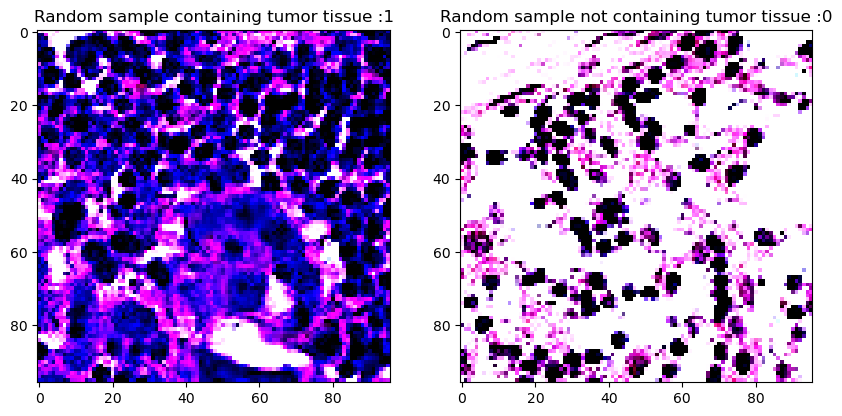

In [16]:
fig, axes = plt.subplots(1,2, figsize = (10, 5))
random_tumor_sample = tumor_validation_samples[random.randint(0, len(tumor_validation_samples)-1)]
random_no_tumor_sample = no_tumor_validation_samples[random.randint(0, len(no_tumor_validation_samples)-1)]

axes[0].imshow(random_tumor_sample[0].transpose(2,0), label ="test")
axes[0].set_title(f"Random sample containing tumor tissue :{random_tumor_sample[1]}")
axes[1].imshow(random_no_tumor_sample[0].transpose(2,0), label = "test")
axes[1].set_title(f"Random sample not containing tumor tissue :{random_no_tumor_sample[1]}")
plt.show()

It looks like tissues that contains tumors have some colored spot or discrepencies (heterogeneous cells), whereas non tumored tissues seem more homogeneous without speficic details.

Now we will plot the distribution of class labels in the training and validation datasets, to see how well the classes are balanced.

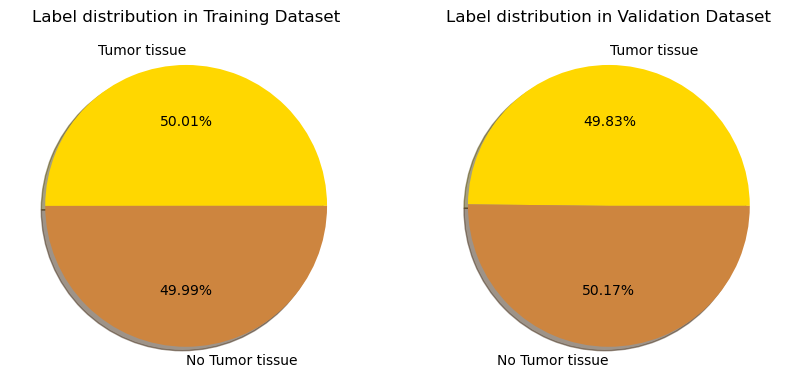

In [17]:
fig, axes = plt.subplots(1, 2, figsize =(10,5))

axes[0].pie([len(tumor_train_samples), len(no_tumor_train_samples)], labels=["Tumor tissue", "No Tumor tissue"], autopct='%.2f%%', shadow=True, colors = ["gold", "peru"])
axes[0].set_title("Label distribution in Training Dataset")
axes[1].pie([len(tumor_validation_samples), len(no_tumor_validation_samples)], labels=["Tumor tissue", "No Tumor tissue"], autopct='%.2f%%', shadow=True, colors = ["gold", "peru"])
axes[1].set_title("Label distribution in Validation Dataset")
plt.show()

Let's write our first CNN model:

In [18]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,stride=1, padding=1)

        self.fc1 = nn.Linear(256*24*24, 512)
        self.fc2 = nn.Linear(512,1)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used : {device}')
model = ConvNet().to(device)

Device used : cuda


Initialization of the training hyperparameters: We will code the whole training loop, where the model is validated after each epoch:

In [ ]:
lr = 0.001
num_epochs = 20
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
metric = tnt.meter.ConfusionMeter(2)

In [ ]:
total_train_losses = []
total_val_losses = []
total_train_accuracies = []
total_val_accuracies = []
for epoch in range(1, num_epochs+1):
    ##TRAINING##
    model.train()
    train_losses = []
    metric.reset()
    print(f'Epoch: {epoch}/{num_epochs}')

    for batch in tqdm(train_dataloader):
        img_batch, lbl_batch = batch

        optimizer.zero_grad()
        outputs = model(img_batch.to(device))
        pred = (outputs > 0.5).float().to(device)
        loss = criterion(outputs, lbl_batch.float().unsqueeze(1).to(device))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        metric.add(pred.squeeze(1), lbl_batch.long())

    total_train_losses.append(np.mean(train_losses))
    train_acc=(np.trace(metric.conf)/float(np.ndarray.sum(metric.conf))) *100
    total_train_accuracies.append(train_acc)

    model.eval()
    val_losses = []
    metric.reset()
    
    for batch in tqdm(val_dataloader):
        img_batch, lbl_batch = batch

        outputs = model(img_batch.float().to(device))
        pred = (outputs > 0.5).float()
        loss = criterion(outputs, lbl_batch.float().unsqueeze(1).to(device))
        val_losses.append(loss.item())
        metric.add(pred.squeeze(1), lbl_batch.long())
        
    total_val_losses.append(np.mean(val_losses))
    val_acc=(np.trace(metric.conf)/float(np.ndarray.sum(metric.conf))) *100
    total_val_accuracies.append(val_acc)

    print('Confusion Matrix:')
    print(metric.conf)
    print(f"Train Loss : {np.mean(train_losses)}, Train Accuracy: {train_acc}")
    print(f"Validation Loss : {np.mean(val_losses)}, Validation Accuracy: {val_acc}")

Epoch: 1/20


100%|██████████| 308/308 [00:04<00:00, 66.40it/s]


Confusion Matrix:
[[3831 1101]
 [ 676 4222]]
Train Loss : 0.47855781529987207, Train Accuracy: 78.15851425582004
Validation Loss : 0.41961115530946036, Validation Accuracy: 81.92268565615463
Epoch: 2/20


100%|██████████| 308/308 [00:04<00:00, 68.37it/s]


Confusion Matrix:
[[3739 1193]
 [ 349 4549]]
Train Loss : 0.39578804578450266, Train Accuracy: 82.29139419304211
Validation Loss : 0.3620549717361664, Validation Accuracy: 84.31332655137335
Epoch: 3/20


100%|██████████| 308/308 [00:04<00:00, 73.17it/s]


Confusion Matrix:
[[3580 1352]
 [ 303 4595]]
Train Loss : 0.3623712026258227, Train Accuracy: 84.187810619932
Validation Loss : 0.38973289338702505, Validation Accuracy: 83.16378433367242
Epoch: 4/20


100%|██████████| 308/308 [00:04<00:00, 64.08it/s]


Confusion Matrix:
[[3968  964]
 [ 340 4558]]
Train Loss : 0.3430996705132382, Train Accuracy: 85.12947946638766
Validation Loss : 0.30676002776274436, Validation Accuracy: 86.73448626653104
Epoch: 5/20


100%|██████████| 308/308 [00:04<00:00, 66.17it/s]


Confusion Matrix:
[[4241  691]
 [ 434 4464]]
Train Loss : 0.31695097603807887, Train Accuracy: 86.50710611212835
Validation Loss : 0.2781455445696007, Validation Accuracy: 88.55544252288911
Epoch: 6/20


100%|██████████| 308/308 [00:04<00:00, 62.84it/s]


Confusion Matrix:
[[4105  827]
 [ 274 4624]]
Train Loss : 0.29263689123727954, Train Accuracy: 87.72778795012643
Validation Loss : 0.26168474249009577, Validation Accuracy: 88.79959308240082
Epoch: 7/20


100%|██████████| 308/308 [00:04<00:00, 68.03it/s]


Confusion Matrix:
[[3899 1033]
 [ 188 4710]]
Train Loss : 0.2691452130779229, Train Accuracy: 88.60842270468218
Validation Loss : 0.2982312138010929, Validation Accuracy: 87.57884028484231
Epoch: 8/20


100%|██████████| 308/308 [00:05<00:00, 61.40it/s]


Confusion Matrix:
[[4305  627]
 [ 295 4603]]
Train Loss : 0.2563451473163428, Train Accuracy: 89.40186589938094
Validation Loss : 0.2339664216080753, Validation Accuracy: 90.6205493387589
Epoch: 9/20


100%|██████████| 308/308 [00:04<00:00, 65.88it/s]


Confusion Matrix:
[[4186  746]
 [ 189 4709]]
Train Loss : 0.24157166376065675, Train Accuracy: 90.09503880024413
Validation Loss : 0.24401118136283204, Validation Accuracy: 90.48830111902339
Epoch: 10/20


100%|██████████| 308/308 [00:04<00:00, 63.15it/s]


Confusion Matrix:
[[4252  680]
 [ 206 4692]]
Train Loss : 0.22937338572187738, Train Accuracy: 90.71409887522887
Validation Loss : 0.23294605626785136, Validation Accuracy: 90.98677517802645
Epoch: 11/20


100%|██████████| 308/308 [00:04<00:00, 61.82it/s]


Confusion Matrix:
[[3968  964]
 [ 100 4798]]
Train Loss : 0.23082957188163675, Train Accuracy: 90.65306478332897
Validation Loss : 0.2709720756392926, Validation Accuracy: 89.17599186164801
Epoch: 12/20


100%|██████████| 308/308 [00:04<00:00, 67.26it/s]


Confusion Matrix:
[[4402  530]
 [ 234 4664]]
Train Loss : 0.21152961545076995, Train Accuracy: 91.57293573982038
Validation Loss : 0.20740609248028916, Validation Accuracy: 92.22787385554425
Epoch: 13/20


100%|██████████| 308/308 [00:04<00:00, 65.45it/s]


Confusion Matrix:
[[4542  390]
 [ 329 4569]]
Train Loss : 0.20173460708585578, Train Accuracy: 91.84758915336995
Validation Loss : 0.19933705901358179, Validation Accuracy: 92.68565615462869
Epoch: 14/20


100%|██████████| 308/308 [00:04<00:00, 65.12it/s]


Confusion Matrix:
[[4673  259]
 [ 411 4487]]
Train Loss : 0.2020975395756536, Train Accuracy: 92.10916383294098
Validation Loss : 0.18582455299238299, Validation Accuracy: 93.18413021363175
Epoch: 15/20


100%|██████████| 308/308 [00:04<00:00, 62.99it/s]


Confusion Matrix:
[[4717  215]
 [ 461 4437]]
Train Loss : 0.18544934676489902, Train Accuracy: 92.75874095387566
Validation Loss : 0.18779519803868058, Validation Accuracy: 93.12309257375382
Epoch: 16/20


100%|██████████| 308/308 [00:04<00:00, 70.93it/s]


Confusion Matrix:
[[4365  567]
 [ 150 4748]]
Train Loss : 0.18393148741888785, Train Accuracy: 92.93748365158253
Validation Loss : 0.18434569888971988, Validation Accuracy: 92.706002034588
Epoch: 17/20


100%|██████████| 308/308 [00:04<00:00, 64.47it/s]


Confusion Matrix:
[[4612  320]
 [ 403 4495]]
Train Loss : 0.1803765363414542, Train Accuracy: 92.97236027552533
Validation Loss : 0.21457481480513696, Validation Accuracy: 92.64496439471007
Epoch: 18/20


100%|██████████| 308/308 [00:04<00:00, 64.84it/s]


Confusion Matrix:
[[4175  757]
 [  87 4811]]
Train Loss : 0.1759224304646212, Train Accuracy: 93.3778010288604
Validation Loss : 0.2176691510400118, Validation Accuracy: 91.41403865717193
Epoch: 19/20


100%|██████████| 308/308 [00:05<00:00, 60.82it/s]


Confusion Matrix:
[[4627  305]
 [ 375 4523]]
Train Loss : 0.1701316833184354, Train Accuracy: 93.46935216671027
Validation Loss : 0.17749152437204724, Validation Accuracy: 93.08240081383519
Epoch: 20/20


100%|██████████| 308/308 [00:05<00:00, 61.15it/s]

Confusion Matrix:
[[4526  406]
 [ 180 4718]]
Train Loss : 0.16107754959014337, Train Accuracy: 93.84863545208823
Validation Loss : 0.1680453887038075, Validation Accuracy: 94.0386571719227


Now we can validate our model, show that it is not overfitting.

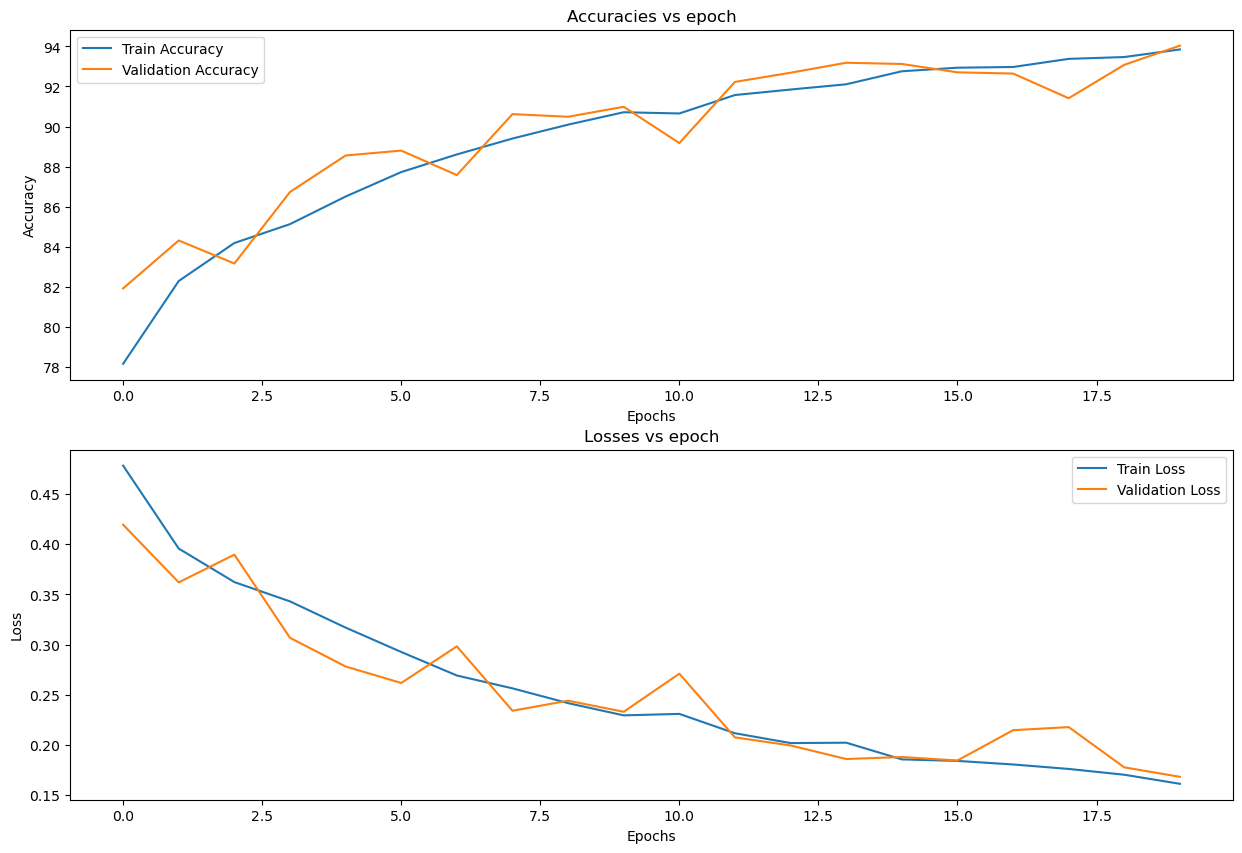

In [20]:
_, axes = plt.subplots(2,1, figsize=(15, 10))
axes[0].plot(total_train_accuracies, label = "Train Accuracy")
axes[0].plot(total_val_accuracies, label = "Validation Accuracy")
axes[0].set_title("Accuracies vs epoch")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[1].plot(total_train_losses, label = "Train Loss")
axes[1].plot(total_val_losses, label = "Validation Loss")
axes[1].set_title("Losses vs epoch")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

I used the confusion matrix as a metric, to be able to get all the metrics in once (accuracy, FPR, TPR then F1-Score). But here we can only look at the training/validation losses and accuracies and see when the model is not overfitting since we transformed validation data (augmentation) we added some noise which makes the model more efficient on non transformed validation data.

We can try to optimize three hyperparameters (the learning rate, the batch size and the number of layers in your CNN model), to see it improves the efficiency of the model.

To do so, we use bayesian optimization to find the best set of hyperparameters using `scikit-optimize` library.

In [20]:
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer, Categorical

In [ ]:
dimensions = [
    Real(1e-5, 1e-1, prior="log-uniform", name="learning_rate"),
    Categorical([16, 32, 64, 128, 256], name="batch_size")
]
parameters_default_values = [
    0.001, #lr
    32 #BATCHSIZE
]
 # default value for each parameter for initialization

In [ ]:
@use_named_args(dimensions=dimensions)
def fit_opt(learning_rate, batch_size):
    model = ConvNet().to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.BCELoss()

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False
    )
    
    model.train()
    for batch in tqdm(train_loader):
        img_batch, lbl_batch = batch
        optimizer.zero_grad()
        outputs = model(img_batch.to(device))
        loss = criterion(outputs, lbl_batch.float().unsqueeze(1).to(device))
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            img_batch, lbl_batch = batch
            outputs = model(img_batch.to(device))
            val_loss += criterion(outputs, lbl_batch.float().unsqueeze(1).to(device)).item()

    score = val_loss / len(val_loader) #We will minimize the mean validation loss

    return score

In [ ]:
gp_result = gp_minimize(
    func=fit_opt,            # Function to minimize
    dimensions=dimensions,   # Search space
    x0=parameters_default_values,
    n_calls=11,
    random_state=42,
    verbose=True
    )

print(f"Optimal set of parameters found at iteration {np.argmin(gp_result.func_vals)}")
print(gp_result.x)

Iteration No: 1 started. Evaluating function at provided point.


100%|██████████| 308/308 [00:04<00:00, 73.93it/s]


Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 37.1853
Function value obtained: 0.4486
Current minimum: 0.4486
Iteration No: 2 started. Evaluating function at random point.


100%|██████████| 615/615 [00:04<00:00, 134.84it/s]


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 46.1203
Function value obtained: 49.8103
Current minimum: 0.4486
Iteration No: 3 started. Evaluating function at random point.


100%|██████████| 154/154 [00:04<00:00, 36.15it/s]


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 37.0166
Function value obtained: 50.1933
Current minimum: 0.4486
Iteration No: 4 started. Evaluating function at random point.


100%|██████████| 615/615 [00:05<00:00, 116.68it/s]


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 50.4293
Function value obtained: 0.3698
Current minimum: 0.3698
Iteration No: 5 started. Evaluating function at random point.


100%|██████████| 308/308 [00:04<00:00, 63.44it/s]


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 42.8670
Function value obtained: 0.4088
Current minimum: 0.3698
Iteration No: 6 started. Evaluating function at random point.


100%|██████████| 77/77 [00:04<00:00, 18.35it/s]


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 207.8575
Function value obtained: 0.4371
Current minimum: 0.3698
Iteration No: 7 started. Evaluating function at random point.


100%|██████████| 77/77 [00:04<00:00, 19.10it/s]


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 204.5565
Function value obtained: 0.4742
Current minimum: 0.3698
Iteration No: 8 started. Evaluating function at random point.


100%|██████████| 615/615 [00:05<00:00, 120.76it/s]


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 51.7148
Function value obtained: 50.1897
Current minimum: 0.3698
Iteration No: 9 started. Evaluating function at random point.


100%|██████████| 77/77 [00:03<00:00, 19.67it/s]


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 203.6237
Function value obtained: 50.1777
Current minimum: 0.3698
Iteration No: 10 started. Evaluating function at random point.


100%|██████████| 615/615 [00:05<00:00, 118.23it/s]


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 54.1688
Function value obtained: 0.6933
Current minimum: 0.3698
Iteration No: 11 started. Evaluating function at random point.


100%|██████████| 154/154 [00:04<00:00, 34.04it/s]


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 38.9038
Function value obtained: 0.4534
Current minimum: 0.3698
Optimal set of parameters found at iteration 3
[0.0006071989493441302, 16]


We can see that regarding the parameters we use we get a better 1-epoch loss even if this method is a bit empiric and depends on the batch etc. Also if we had more computing ressource we could do many more grid search cross validation to fine tune the model, but here we are limited. 

We couldn't fine tune the number of layers used in the convolutional layer, but it can be a very impactful hyperparameter to finetune (same for the probabilty of dropout, number of maxpool, size of the Fully connected layers)

However let's plot the losses vs batch sizes and learning rates (with the other parameter fixed):

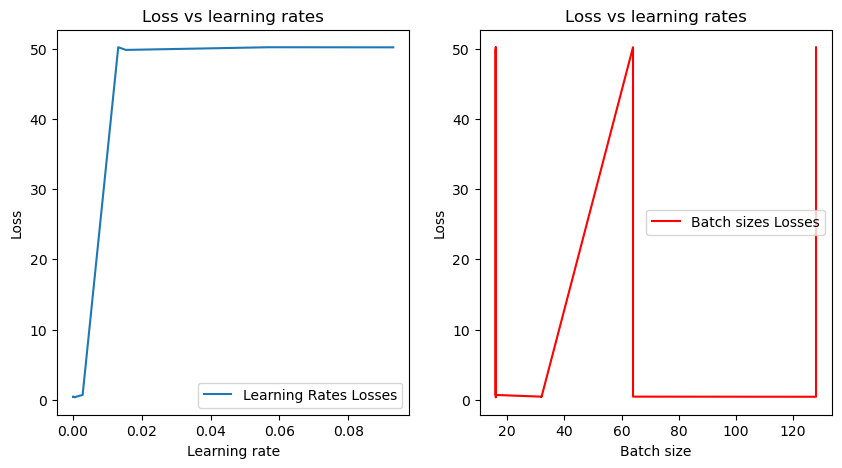

In [70]:
learning_rates = np.array(gp_result.x_iters)[:,0]
sorted_args_lr = np.argsort(learning_rates)
batch_sizes = np.array(gp_result.x_iters)[:,1]
sorted_args_bs = np.argsort(batch_sizes)

_, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].plot(np.sort(learning_rates), gp_result.func_vals[sorted_args_lr], label="Learning Rates Losses")
axes[0].set_xlabel("Learning rate")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs learning rates")
axes[0].legend()
axes[1].plot(np.sort(batch_sizes), gp_result.func_vals[sorted_args_bs], label="Batch sizes Losses", color = 'red')
axes[1].set_xlabel("Batch size")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss vs learning rates")
axes[1].legend()
plt.show()

For the batch sizes, it's hard to discuss on the efficiency of the chosen parameters, because it's for fixed learning rate. Here the learning rate is way more impactful on the losses which makes sens because a big learning rate causes the loss function to not converge at all.

Also instead of using self made convnet we can use well known architectures such as vgg16 which (after some research) is very efficient on this kind of classification tasks

### Explainability

With the exception of using Saliency maps, we can use one other interpretability method such as GradCAM
With respect to the code block below, saliency maps are useful in interpreting the decisions of CNNs. However, they have some limitations.

c:\Users\ismoi\anaconda3\envs\ai\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


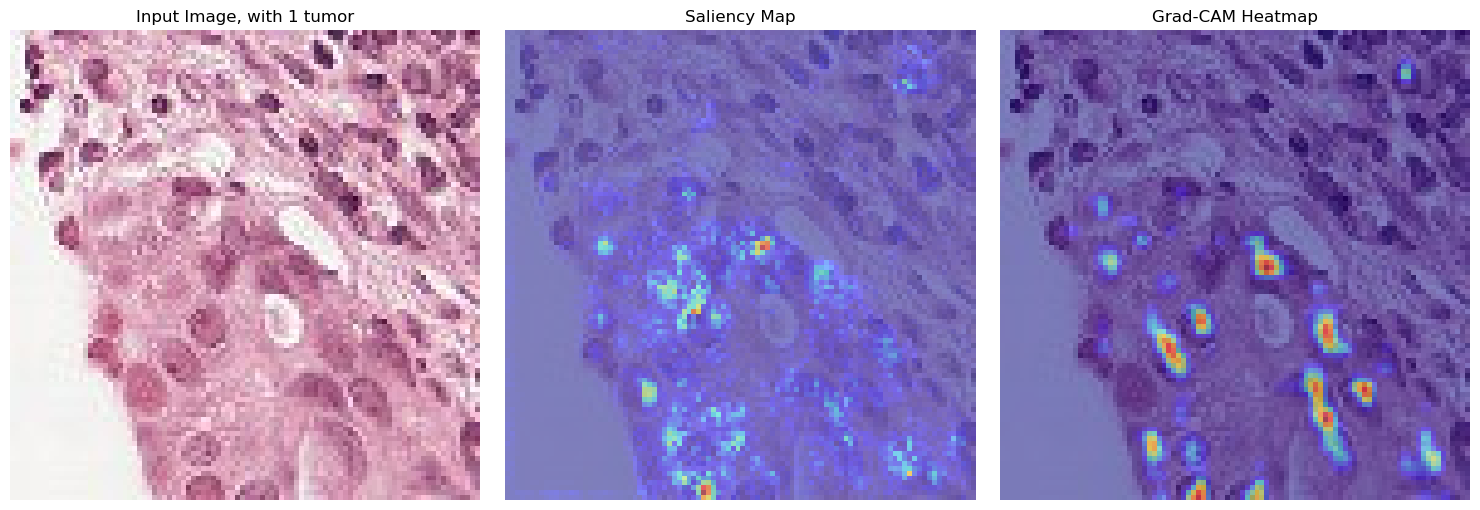

In [ ]:
## Code block to use saliency maps
import cv2

image = images[40]
label = labels[40]

preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
              ]) ### Here put the transforms to be applied

input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

model.eval()

# Set the requires_grad attribute of the input tensor to True for gradients
input_tensor.requires_grad_(True)

# Forward pass to get the model prediction
output = model(input_tensor.to(device))

# Choose the class index for which you want to visualize the saliency map
class_index = torch.argmax(output)

model.zero_grad()

# Backward pass to get the gradients of the output w.r.t the input
output[0, class_index].backward()

# Get the gradients from the input tensor
saliency_map = input_tensor.grad.squeeze(0).abs().cpu().numpy()

# Normalize the saliency map for visualization (optional)
saliency_map = saliency_map / saliency_map.max()

normalized_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

# Convert the saliency map back to a uint8 image format (0-255)
saliency_map_image = np.uint8(255 * normalized_saliency_map)

# Aggregate across the channels
aggregate_saliency = saliency_map.sum(axis=0)

# Plot the input image and its corresponding saliency map side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the input image
axes[0].imshow(image)
axes[0].set_title(f'Input Image, with {label} tumor')
axes[0].axis('off')

# Plot the saliency map
axes[1].imshow(aggregate_saliency, cmap='jet', alpha=0.7)  # Overlay saliency map on the input image
axes[1].imshow(image, alpha=0.3)  # Overlay input image for comparison
axes[1].set_title('Saliency Map')
axes[1].axis('off')

## Grad-CAM
#The following function registers the gradient and activations of our last layer
def register_hooks(layer):
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)

    return gradients, activations

#We compute them here
gradients, activations = register_hooks(model.conv4)

# Forward pass to get the model prediction
output = model(input_tensor.to(device))

# Choose the class index for which you want to visualize the Grad-CAM (this time)
target_class = torch.argmax(output)

# Backward pass to get the gradients of the output w.r.t the input
model.zero_grad()
output[0, target_class].backward()

# Extract the gradients and activations
gradients = gradients[0].detach() 
activations = activations[0].detach() 

# Compute the heatmap
weights = gradients.mean(dim=[2, 3], keepdim=True)
gradcam = F.relu((weights * activations).sum(dim=1)).squeeze(0) 
gradcam -= gradcam.min()
gradcam /= gradcam.max()

gradcam_resized = cv2.resize(gradcam.cpu().numpy(), (image.shape[0], image.shape[1]))

# Plot the Grad-CAM heatmap
axes[2].imshow(image)
axes[2].imshow(gradcam_resized, cmap='jet', alpha=0.5)
axes[2].set_title("Grad-CAM Heatmap")
axes[2].axis('off')

plt.tight_layout()
plt.show()

Grad-CAM generates a heatmap by computing the gradients of the target class with respect to the feature maps of a specific convolutional layer label, it uses these gradients to weight the activations, highlighting regions of the image that strongly influence the model's classification.

Here, it seems that the Grad-CAM heatmap highlights biologically relevant regions, such as small tissue structures, which align with human intuition for the task. The results appear to make sense for this classification since it's focusing on hetergeneous regions. It's hard to really interpret without the knowledge of a specialist, so it's only an intuition.

The limitations, we can see on this example that interpretations can be noisy or maybe focus irrelevant things (especially in the Saliency Map below)

Also Grad-CAM depends on the choice of the layer which may not align with meaningful features and CNN remains black boxes at higher levels so complete transparency can be challenging. Some versions of Grad-CAM improve it such as Grad CAM ++ which refine the heatmap by considering the importance of individual pixels for multilple instance of the same class.

## Traning a Visual Transformer

In [11]:
from torchvision import models
class ViT(nn.Module):
    def __init__(self):
        super(ViT, self).__init__()
        self.vit = models.vit_b_16(pretrained=True)
        self.vit.heads = nn.Linear(self.vit.heads.head.in_features, 1) #The head is custom here

    def forward(self, x):
        return torch.sigmoid(self.vit(x))


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used : {device}')
model = ViT().to(device)

Device used : cuda


c:\Users\ismoi\anaconda3\envs\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ismoi\anaconda3\envs\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
lr = 0.0001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 10

In [19]:
#we can add a metric as before

transform = transforms.Compose([
    transforms.Resize((224, 224))
])

for epoch in range(num_epochs):
    #Training
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_dataloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(transform(inputs))
        loss = criterion(outputs, labels.float().unsqueeze(0).T)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_dataloader)}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            batch = inputs, labels
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_loss / len(val_dataloader)}, Accuracy: {100 * correct / total:.2f}%")

torch.save(model.state_dict(), 'tumor_vit_model.pth')

  1%|          | 4/717 [00:36<1:47:31,  9.05s/it]


KeyboardInterrupt: 